Some pointers:

1. Logistic regression is the workhorse of machine learning.
2. Before deep learning era, logistic regression was the default choice for solving real life
classification problems with hundreds of thousands of features.
3. It works in binary, multi-class and multi-label classification set ups.


In [5]:
# Imports:

import numpy as np
from pprint import pprint
from tempfile import mkdtemp
from shutil import rmtree

# to make this notebook output stable across the runs:
np.random.seed(42)

# sklearn specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

# scipy
from scipy.stats import loguniform

# to plot the pretty figures
%matplotlib inline
import matplotlib.pyplot as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc("axes", labelsize = 14)
mpl.rc('xtick', labelsize = 12)
mpl.rc('ytick', labelsize = 12)
mpl.rc('figure', figsize = (8,6))




In [6]:
# Ignore all the warnings (convergence ...) by sklearn

def warn(*args, **kwargs):
  pass

import warnings
warnings.warn = warn

# Note on classification steps

Each classifier implemented for addressing this problem has the following steps:
* Preprocessing
* Classification
* Train with cross validation
* [Optional] Hyper-parameter tuning
* Performance evaluation




# handwritten digit classification

We are going to repeat the digit recognition task with the following classifiers
1. SGD classifier.
2. Logistic Regression.
3. Ridge Classifier.

We make use of same **MNIST** dataset.

In [7]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version = 1, return_X_y = True)

In [8]:
# convert to numpy array

X = X_pd.to_numpy()
y = y_pd.to_numpy()

# Preprocessing

* Unlike perceptron, where scaling the range is optional (but recommended), sigmoid
requires scaling the feature range between 0 to 1.
* Contemplate the consequences if we don't apply the scaling operation on the input
datapoints.
* Note: Do not apply mean centering as it removes zeros from the data, however, zeros
should be zeros in the dataset
* Since we already visualized the samples in the dataset and know sufficient details, we are
going to use pipeline to make the code compact.

In [12]:
scaler = MinMaxScaler()
x = scaler.fit_transform(X)

In [14]:
# Mean
np.mean(X)

33.385964741253645

In [16]:
# sd
np.std(X)

78.65437362689433

In [17]:
# min and max
np.min(X), np.max(X)

(0.0, 255.0)

In [26]:
# lets get some more information about the dataset:

target_names = np.unique(y)

# number of samples
X.shape[0], X.dtype

(70000, dtype('float64'))

In [27]:
# Number of features:

X.shape[1]

784

In [28]:
# number of classes and names of classes

len(target_names) , y.dtype, target_names


(10,
 dtype('O'),
 array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object))

# Data Visualization:

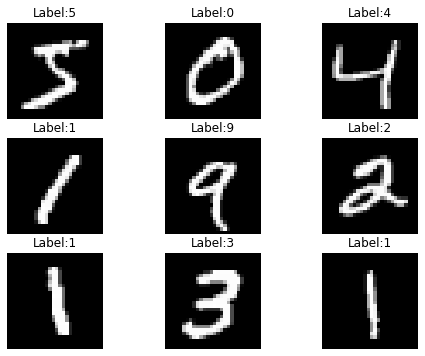

In [29]:
num_images = 9 # choose the square number
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows= factor, ncols = factor, figsize = (8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()

# data split

In [30]:
# Split the dataset into training and testing set.

x_train,x_test,y_train,y_test = X[:60000], X[60000:], y[:60000], y[60000:]

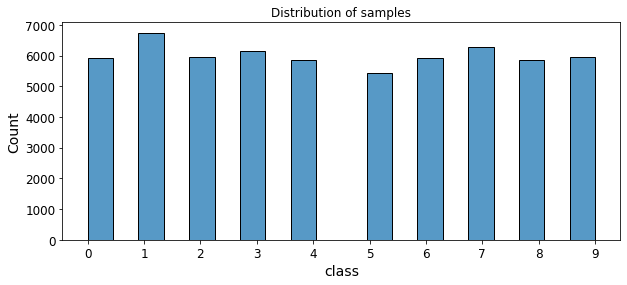

In [32]:
# check if the dataset is balanced or not

plt.figure(figsize = (10,4))
sns.histplot(data= np.int8(y_train), binwidth = 0.45, bins = 11)
plt.xticks(ticks = [0,1,2,3,4,5,6,7,8,9], labels = [0,1,2,3,4,5,6,7,8,9])
plt.xlabel('class')
plt.title('Distribution of samples')
plt.show()

# Binary Classification : 0-Detector

* Let us start with a simple classification problem, that is, binary classification.
* Since the original label vector contains 10 classes, we need to modfiy the number of
classes to 2. Therefore, the label '0' will be changed to '1' and all other labels (1-9) will be
changed to '0'.
(Important: for perceptron we set the negative labels to -1)

In [33]:
# intialize new variable names with all -1

y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

In [34]:
# find indices of digit 0 image
indx_0 = np.where(y_train =='0') # remember original labels are of type str not int
# use those indices to modify y_train_0&y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

Sanity check
* Let's display the elements of y_train and y_train_0 to verify whether the labels are
properly modified.

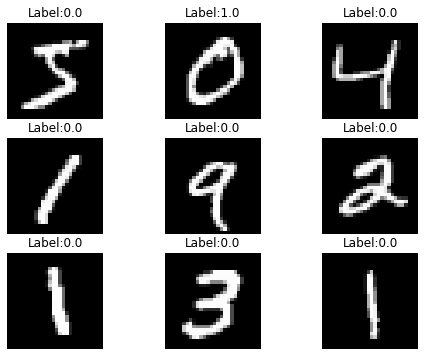

In [35]:
num_images = 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

# Baseline Model:

1. Count the number of samples per class
2. the model always outputs the class which has the highestnumber of samples
3. then calculate the accuracy of the baseline model

In [40]:
num_pos = len(np.where(y_train_0==1)[0])
num_neg = len(np.where(y_train_0==0)[0])
print(num_pos,num_neg)

5923 54077


In [41]:
base_clf = DummyClassifier(strategy = 'most_frequent')
base_clf.fit(x_train, y_train_0)
print(base_clf.score(x_train, y_train_0))

0.9012833333333333


In [43]:
# verification
54077/(54077+5923)

0.9012833333333333

# Logistic Regression model

Let's look into the paramters of the SGDClassifier() estimator implemented in sklearn:
class sklearn.linear_model.SGDClassifier(loss='hinge', *, penalty='l2',
alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001,
shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None,
learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False,
validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False,
average=False) .

Setting the loss parameter to 'loss=log' makes it a logistic regression classifier.
We may refer to documentation for more details on the SGDClassifier class.

# Training without regularization

* Let's instatiate an object of SGDClassifier.
* Since we want to plot learning curve of training, we set max_iter = 1 and
warm_start=True .
* In addition, we are using constant learning rate throughout the training. For that we set
learning_rate='constant' and set the learning rate through eta0=0.01 .
* Since we are not using regularization, we set alpha=0 .

set eta0 = 0.01, leaning_rate = 'constant' and alpha = 0

In [49]:
estimator = SGDClassifier(loss = 'log',
                            penalty = 'l2',
                            max_iter = 1,
                            eta0 = 0.01,
                            alpha = 0,
                            learning_rate = 'constant',
                            random_state = 1729,
                            warm_start = True
                            )

pipe_sgd = make_pipeline(MinMaxScaler(), estimator)

Loss = []
iterations = 100

for i in range(iterations):
  pipe_sgd.fit(x_train, y_train_0)
  y_pred = pipe_sgd.predict_proba(x_train)
  Loss.append(log_loss(y_train_0, y_pred))

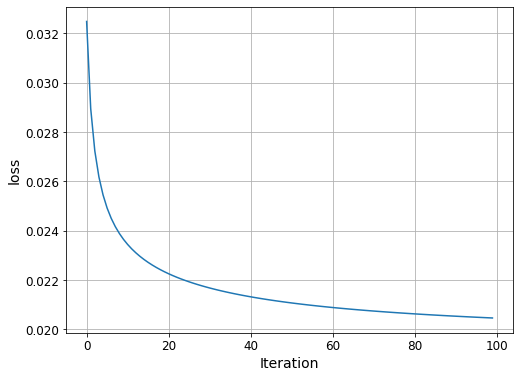

In [50]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.show()

In [51]:
# need to check here how the loss function changes if we dont do the min max scaling

In [52]:
# Now that the model is trained, let's us calculate the training and test accuracy of the model.

print('Training accuracy: %.2f'%pipe_sgd.score(x_train,y_train_0))
print('Testing accuracy: %.2f'%pipe_sgd.score(x_test,y_test_0))

Training accuracy: 0.99
Testing accuracy: 0.99


In [53]:
# We know that accuracy alone is not a good metric for binary classification.
# Let's compute Precision, recall and f1-score for the model.

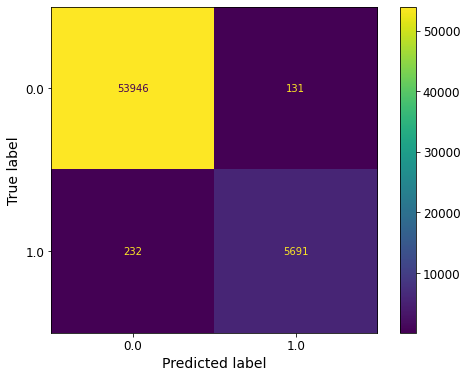

In [55]:
y_hat_train_0 = pipe_sgd.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format = '.5g')
plt.show()

In [58]:
print(classification_report(y_train_0, y_hat_train_0))
# since we are rounding the digits we are getting the score of 1

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



In [59]:
# Observe that the off-diagonal elements are not zero, which indicates that a few examples are
# misclassified.
print(classification_report(y_train_0, y_hat_train_0, digits=3))



              precision    recall  f1-score   support

         0.0      0.996     0.998     0.997     54077
         1.0      0.977     0.961     0.969      5923

    accuracy                          0.994     60000
   macro avg      0.987     0.979     0.983     60000
weighted avg      0.994     0.994     0.994     60000



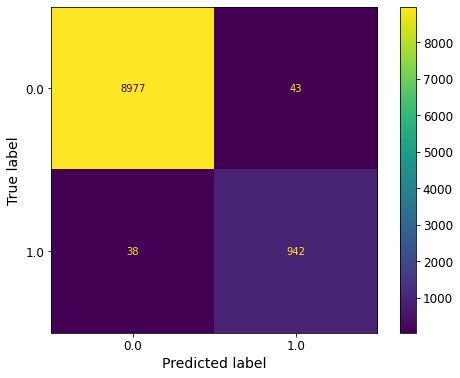

In [61]:
# Let's generate classification report on test set.

y_hat_test_0 = pipe_sgd.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0,values_format='.5g')
plt.show()

In [62]:
print(classification_report(y_test_0, y_hat_test_0, digits=3))

              precision    recall  f1-score   support

         0.0      0.996     0.995     0.996      9020
         1.0      0.956     0.961     0.959       980

    accuracy                          0.992     10000
   macro avg      0.976     0.978     0.977     10000
weighted avg      0.992     0.992     0.992     10000



# Cross validation

In [63]:
estimator = SGDClassifier(loss = 'log',
                            penalty = 'l2',
                            max_iter = 100,
                            eta0 = 0.01,
                            alpha = 0,
                            learning_rate = 'constant',
                            random_state = 1729,
                            warm_start = False
                            )

# create a pipeline
pipe_sgd_cv = make_pipeline(MinMaxScaler(), estimator)



In [64]:
# Now we will train the classifier with cross validation.

cv_bin_clf = cross_validate(pipe_sgd_cv,
                            x_train,
                            y_train_0,
                            cv=5,
                            scoring=['precision','recall','f1'],
                            return_train_score=True)

pprint(cv_bin_clf)

{'fit_time': array([2.24622345, 1.23981237, 1.22334194, 1.71431518, 1.19874477]),
 'score_time': array([0.06579614, 0.06480861, 0.06656003, 0.06663823, 0.0663867 ]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.95952782]),
 'test_recall': array([0.95861486, 0.94510135, 0.95105485, 0.95021097, 0.96033755]),
 'train_f1': array([0.96495899, 0.96565657, 0.96453452, 0.96373944, 0.96302557]),
 'train_precision': array([0.97419355, 0.97321046, 0.96473818, 0.97701149, 0.96404399]),
 'train_recall': array([0.95589787, 0.95821903, 0.96433094, 0.95082313, 0.96200929])}


In [65]:
# from the above result we can see that logistic regression is performing better than the perceptron
# however, it is a good to check the weight values of all the features and decide whether the regularization could be of any help

In [68]:
# call the estimator object in the steps of pipeline
weights = pipe_sgd[1].coef_
bias = pipe_sgd[1].intercept_
print('Dimention of Weights w: {0}'.format(weights.shape))
print('Bias :{0}'.format(bias))

Dimention of Weights w: (1, 784)
Bias :[-4.89339106]


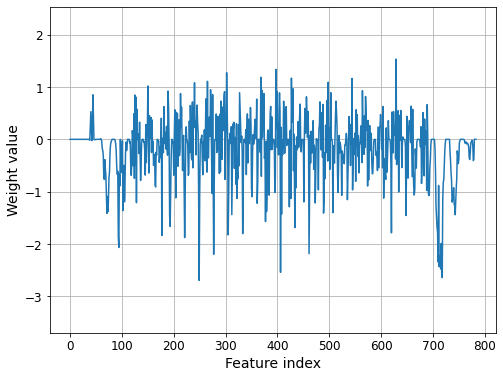

In [73]:
plt.figure()
plt.plot(np.arange(0,784),weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights)-1, np.max(weights)+1)
plt.grid()

* It is interesting to observe how many weight values are exactly zero.
* Those features contribute nothing in the classification.

In [74]:
num_zero_w = weights.shape[1]-np.count_nonzero(weights)
print('Number of weights with value zero:%f'%num_zero_w)

Number of weights with value zero:67.000000


Looking at the above plot and the performance of the model on training and test, it is
obvious that the model do not require any regularization.

# Training with regularization

However, what happens to the performance of the model if we penalize, out of temptation,
the weight values even to a smaller degree.
Think about it.

In [79]:
bin_sgd_clf_l2 = SGDClassifier(loss = 'log',
                            penalty = 'l2',
                            max_iter = 1,
                            eta0 = 0.01,
                            alpha = 0.001,
                            learning_rate = 'constant',
                            random_state = 1729,
                            warm_start = True
                            )

# create a pipeline
pipe_sgd_clf_l2 = make_pipeline(MinMaxScaler(), bin_sgd_clf_l2)

In [80]:
loss = []
iterations = 100
for i in range(iterations):
  pipe_sgd_clf_l2.fit(x_train, y_train_0)
  y_pred = pipe_sgd_clf_l2.predict_proba(x_train)
  loss.append(log_loss(y_train_0, y_pred))

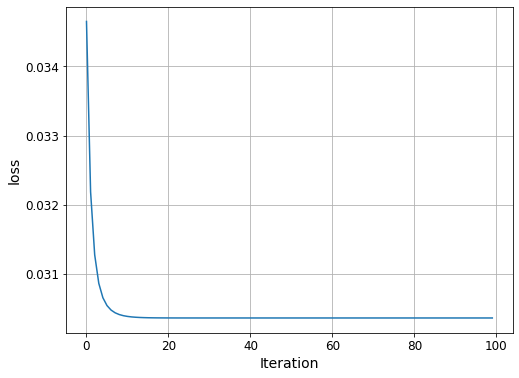

In [81]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.show()

In [82]:
# loss is slightly higher than non-regularised model

In [86]:
weights = bin_sgd_clf_l2.coef_
bins = bin_sgd_clf_l2.intercept_
print(bias)

[-4.89339106]


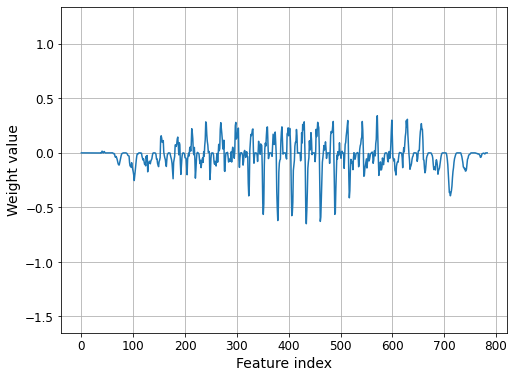

In [87]:
plt.figure()
plt.plot(np.arange(0,784),weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights)-1, np.max(weights)+1)
plt.grid()

In [88]:
num_zero_w = weights.shape[1]-np.count_nonzero(weights)
print('Number of weights with value zero:%f'%num_zero_w)

Number of weights with value zero:67.000000


In [89]:
# exactly 67 are zero again

In [90]:
print('Training accuracy: %.2f'%pipe_sgd_clf_l2.score(x_train,y_train_0))
print('Testing accuracy: %.2f'%pipe_sgd_clf_l2.score(x_test,y_test_0))

Training accuracy: 0.99
Testing accuracy: 0.99


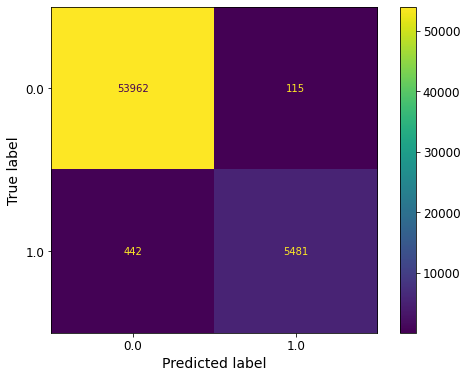

In [91]:
y_hat_train_0 = pipe_sgd_clf_l2.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format = '.5g')
plt.show()

In [92]:
print(classification_report(y_train_0, y_hat_train_0))
# since we are rounding the digits we are getting the score of 1

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



# display Input images and their predictions

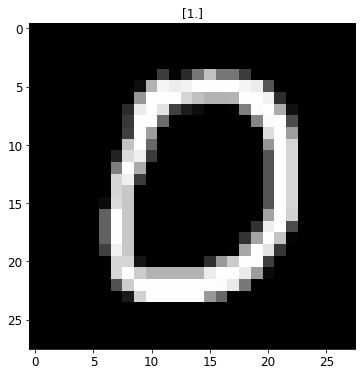

In [95]:
index = 10
plt.imshow(x_test[index,:].reshape(28,28), cmap = 'gray')
pred = bin_sgd_clf_l2.predict(x_test[index].reshape(1,-1))
plt.title(str(pred))
plt.show()

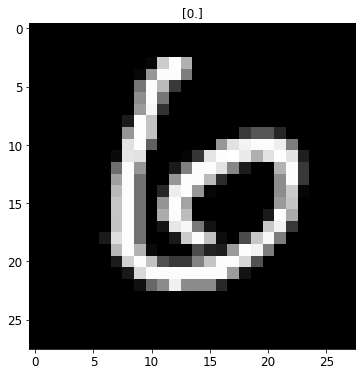

In [96]:
index = 11
plt.imshow(x_test[index,:].reshape(28,28), cmap = 'gray')
pred = bin_sgd_clf_l2.predict(x_test[index].reshape(1,-1))
plt.title(str(pred))
plt.show()

# Hyper-parameter tuning

* The learning rate and regularization rate are two important hyper-parameters of
sgdclassifier.
* Let's use RandomizedSearchCV() and draw the value from the log-uniform distribution to
find a better combination of eta and alpha

In [97]:
eta_grid = loguniform(1e-3,1e-1)
alpha_grid = loguniform(1e-7,1e-1)

* Note that, `eta_grid` & `alpha_grid` are objects that contain a method called `rvs()` which
can be called to get random values of given size.
* Therefore, we pass this `eta_grid` & `alpha_grid` objects to `RandomizedSearchCV()` .
Internally, it makes use of this `rvs()` method of these objects for sampling.

In [98]:
print(eta_grid.rvs(10, random_state=42))

[0.00561152 0.07969455 0.02910636 0.01575132 0.00205134 0.00205111
 0.00130667 0.05399484 0.01593052 0.02607025]


In [99]:
estimator= SGDClassifier(loss='log',
                         penalty='l2',
                         max_iter=100,
                         warm_start=False,
                         learning_rate='constant',
                         eta0=0.01,
                         alpha=0,
                         random_state=1729)

In [100]:
pipe_sgd_hpt = make_pipeline(MinMaxScaler(),estimator)

In [101]:
print(pipe_sgd_hpt)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant',
                               loss='log', max_iter=100, random_state=1729))])


In [102]:
scores = RandomizedSearchCV(pipe_sgd_hpt,
                            param_distributions={
                                'sgdclassifier__eta0':eta_grid,
                                'sgdclassifier__alpha':alpha_grid},
                            cv=5,
                            scoring='precision',
                            n_iter=10,
                            refit=True,
                            random_state=1729)

In [103]:
# It take quite a long time to finish
scores.fit(x_train,y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('sgdclassifier',
                                              SGDClassifier(alpha=0, eta0=0.01,
                                                            learning_rate='constant',
                                                            loss='log',
                                                            max_iter=100,
                                                            random_state=1729))]),
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbb428be610>,
                                        'sgdclassifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbb428be370>},
                   random_state=1729, scoring='precision')

In [104]:
pprint(scores.cv_results_)

{'mean_fit_time': array([1.34268517, 1.60142083, 1.46754823, 1.48677187, 1.39191961,
       1.27229385, 1.47247572, 1.32848239, 1.03382535, 1.16460676]),
 'mean_score_time': array([0.05047398, 0.05142212, 0.05831046, 0.05269442, 0.0543654 ,
       0.050526  , 0.04704847, 0.04896045, 0.0502614 , 0.04925137]),
 'mean_test_score': array([0.96460118, 0.96414504, 0.96737133, 0.96151669, 0.9884984 ,
       0.96578734, 0.96148015, 0.96354983, 0.98956494, 0.96552555]),
 'param_sgdclassifier__alpha': masked_array(data=[1.8747854362378862e-06, 3.476412314661177e-05,
                   0.0014239854561506498, 5.312503633759702e-06,
                   0.05828730756092898, 2.521634683952945e-07,
                   0.00011448262369494136, 1.1186816059037773e-05,
                   0.058121543505891174, 0.003268914620727034],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'param_sgdclassifi

In [106]:
# Let us pick the best estimator from the results

best_bin_clf = scores.best_estimator_

In [110]:
best_bin_clf[1]

SGDClassifier(alpha=0.058121543505891174, eta0=0.01690864669305596,
              learning_rate='constant', loss='log', max_iter=100,
              random_state=1729)

In [107]:
y_hat_train_best_0 = best_bin_clf.predict(x_train)

In [108]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     54077
         1.0       0.98      0.79      0.88      5923

    accuracy                           0.98     60000
   macro avg       0.98      0.90      0.93     60000
weighted avg       0.98      0.98      0.98     60000



# classification report

precisson recall tradeoff

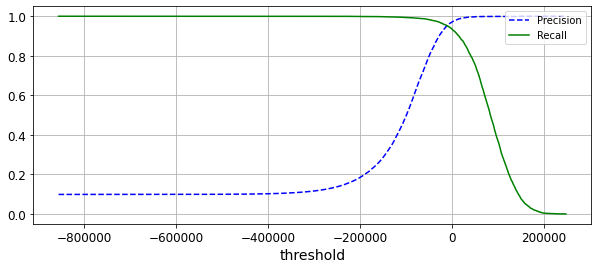

In [113]:
from sklearn.metrics import precision_recall_curve

y_scores = bin_sgd_clf.decision_function(x_train)
precisions , recalls, thresholds = precision_recall_curve(y_train_0, y_scores)
plt.figure(figsize = (10,4))
plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
plt.xlabel("threshold")
plt.grid(True)
plt.legend(loc = 'upper right')
plt.show()

In [114]:
# ROC Curve and other curves missing from here